## Steps to run this notebook:
1. Go to sslvpn.asu.edu and install the Cisco AnyConnect Client VPN
• Faculty, staff, and students will also need Duo Two-Factor
Authentication
2. In the connect window, enter “sslvpn.asu.edu/2fa”
3. Sign in with ASURITE, ASU password, and DUO two-factor
authentication method
4. Login to sol using: https://sol.asu.edu/
5. Select Jupyter Notebook server and launch the server selecting the required cores, hour of operation and hackathon sbatch options code.

# Base Model Interface

In [ ]:
import os
import gradio as gr
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

In [ ]:
model_name = '/data/datasets/community/huggingface/Llama3-8b-instruct/'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name,torch_dtype = torch.float16, device_map = "auto")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
class LLMChat:
    def __init__(self, tokenizer, model):
        self.tokenizer = tokenizer
        self.model = model
        self.history = []

        # THE CRITICAL FIX: Both Llama 3 stop tokens
        self.terminators = [
            tokenizer.eos_token_id,  # <|end_of_text|> (128001)
            tokenizer.convert_tokens_to_ids("<|eot_id|>")  # <|eot_id|> (128009)
        ]

    def send(self, user_text, temperature=0.6, top_p=0.9):
        # Add user message to history
        self.history.append({"role": "user", "content": user_text.strip()})

        # Build messages with system prompt
        messages = [{"role": "system", "content": "You are a helpful assistant."}]
        messages.extend(self.history)

        # Use Llama 3's official chat template
        input_ids = self.tokenizer.apply_chat_template(
            messages,
            add_generation_prompt=True,  # Critical for proper response
            return_tensors="pt"
        ).to(self.model.device)

        # Generate with BOTH stop tokens - this prevents self-conversation
        outputs = self.model.generate(
            input_ids,
            max_new_tokens=2000,
            eos_token_id=self.terminators,  # THE KEY FIX
            pad_token_id=self.tokenizer.eos_token_id,
            do_sample=True,
            temperature=temperature,
            top_p=top_p,
            repetition_penalty=1.1
        )

        # Extract only the new response tokens
        response_tokens = outputs[0][input_ids.shape[-1]:]
        response = self.tokenizer.decode(response_tokens, skip_special_tokens=True).strip()

        # Add assistant response to history
        if response:
            self.history.append({"role": "assistant", "content": response})

        return response

    def clear_history(self):
        self.history = []

In [ ]:
# Initialize your chat instance
chat = LLMChat(tokenizer, model)

def chat_fn(message, history, temperature, top_p):
    """Process chat message and return updated history"""
    # Get response from LLMChat
    response = chat.send(message)

    # Update gradio history format
    history.append([message, response])
    return history, ""

def clear_chat():
    """Clear chat history"""
    chat.clear_history()
    return []

# Agentic RAG with Local Ollama Model
This notebook demonstrates how to build a Retrieval-Augmented Generation (RAG) agent using LangGraph, LangChain, and a local  model run via Ollama.

Adapted from: https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_agentic_rag/

## Materials
This notebook and all materials referenced here can be found on Sol `/data/sse/ai-accelerated-spark`.

## 1. Import libraries

In [ ]:
from langchain_core.prompts import PromptTemplate
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langchain_core.tools import Tool
from langgraph.graph import Graph
from langchain.text_splitter import CharacterTextSplitter
from sentence_transformers import SentenceTransformer
from transformers import pipeline
import torch
from typing import List
from pydantic import BaseModel, Field
import os

os.environ["USER_AGENT"] = "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109.0) Gecko/20100101 Firefox/109.0"

## 2. Preprocess documents
### 2.1. Fetch documents

In [ ]:
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://medium.com/rapids-ai",
    "https://medium.com/cupy-team/announcing-cupy-v13-66979ee7fab0",
    "https://www.unum.cloud/blog/2022-01-26-cupy",
    "https://docs.nvidia.com/cuda/"
]

docs = [WebBaseLoader(url).load() for url in urls]

In [ ]:
docs[0][0].page_content.strip()[:1000]

'RAPIDS AI - MediumHomepageOpen in appSign inGet startedRAPIDS AIRAPIDS is a suite of software libraries for executing end-to-end data science & analytics pipelines entirely on GPUs.RAPIDS ReleasesDataFramesMachine LearningData VisualizationGraph AnalyticsNLPLearn MoreFollowRAPIDS 24.08: Better scalability, performance, and CPU/GPU interoperabilityRAPIDS 24.08: Better scalability, performance, and CPU/GPU interoperabilityRAPIDS 24.08 is now available with significant updates geared towards processing larger workloads and seamless CPU/GPU interoperability.Manas SinghAug 27, 2024RAPIDS 24.04 ReleaseRAPIDS 24.04\xa0ReleaseExpanded accelerated vector search and zero-code change data science, Dask query planning, and support for Python 3.11 and pandas\xa02Nick BeckerApr 24, 2024RAPIDS 24.02 releaseRAPIDS 24.02\xa0releaseZero code-change NetworkX, RAPIDS on Databricks with Dask, and\xa0more!Alex RavenelFeb 22, 2024RAPIDS 23.10 ReleaseRAPIDS 23.10\xa0ReleaseRAPIDS Goes CPU/GPU (zero code chan

### 2.2. Split the fetched documents into smaller chunks for indexing into the vectorstore

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

In [ ]:
doc_splits[0].page_content

'RAPIDS AI - MediumHomepageOpen in appSign inGet startedRAPIDS AIRAPIDS is a suite of software libraries for executing end-to-end data science & analytics pipelines entirely on GPUs.RAPIDS ReleasesDataFramesMachine LearningData VisualizationGraph AnalyticsNLPLearn MoreFollowRAPIDS 24.08: Better scalability, performance, and CPU/GPU interoperabilityRAPIDS 24.08: Better scalability, performance, and CPU/GPU'

## 3.Create a retriever tool
### 3.1. Use an in-memory vector store and all-MiniLM-L6-V2 embeddings model

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np

class LlamaEmbeddings:
    def __init__(self, model_path):
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.model = AutoModel.from_pretrained(
            model_path,
            torch_dtype=torch.float16,  # Use half precision to save memory
            device_map="auto"
        )

        # Add padding token if it doesn't exist
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

    def embed_documents(self, texts):
        embeddings = []
        for text in texts:
            # Tokenize
            inputs = self.tokenizer(
                text,
                return_tensors="pt",
                truncation=True,
                padding=True,
                max_length=512
            )

            # Get hidden states
            with torch.no_grad():
                outputs = self.model(**inputs)
                # Use mean pooling of last hidden state
                hidden_states = outputs.last_hidden_state
                attention_mask = inputs['attention_mask']

                # Mean pooling
                embeddings_tensor = (hidden_states * attention_mask.unsqueeze(-1)).sum(1) / attention_mask.sum(-1).unsqueeze(-1)
                embeddings.append(embeddings_tensor.cpu().numpy())

        return np.vstack(embeddings)

    def embed_query(self, text):
        return self.embed_documents([text])[0]

# Usage with LangChain
from langchain_core.embeddings import Embeddings

class LangChainLlamaEmbeddings(Embeddings):
    def __init__(self, model_path):
        self.llama_embedder = LlamaEmbeddings(model_path)

    def embed_documents(self, texts):
        return self.llama_embedder.embed_documents(texts).tolist()

    def embed_query(self, text):
        return self.llama_embedder.embed_query(text).tolist()

# Use it
embedding_model = LangChainLlamaEmbeddings("/data/datasets/community/huggingface/Llama3-8b-instruct/")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
from sentence_transformers import SentenceTransformer
import torch

# This approach tries to adapt the model
class LlamaSentenceTransformer:
    def __init__(self, model_path):
        # Load as base transformer model
        from transformers import AutoModel, AutoTokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.model = AutoModel.from_pretrained(
            model_path,
            torch_dtype=torch.float16,
            device_map="auto"
        )

        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

    def encode(self, sentences, convert_to_tensor=False):
        if isinstance(sentences, str):
            sentences = [sentences]

        embeddings = []
        for sentence in sentences:
            inputs = self.tokenizer(
                sentence,
                return_tensors="pt",
                truncation=True,
                padding=True,
                max_length=512
            )

            with torch.no_grad():
                outputs = self.model(**inputs)
                # Mean pooling
                attention_mask = inputs['attention_mask']
                token_embeddings = outputs.last_hidden_state
                input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
                embeddings.append(torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9))

        result = torch.cat(embeddings, dim=0)
        if convert_to_tensor:
            return result
        return result.cpu().numpy()

In [ ]:
from transformers import AutoTokenizer, AutoModel, BitsAndBytesConfig
import torch

# Use 4-bit quantization to reduce memory usage
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

class QuantizedLlamaEmbeddings:
    def __init__(self, model_path):
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.model = AutoModel.from_pretrained(
            model_path,
            quantization_config=quantization_config,
            device_map="auto"
        )

        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

    def get_embeddings(self, texts, batch_size=1):
        all_embeddings = []

        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]

            inputs = self.tokenizer(
                batch_texts,
                return_tensors="pt",
                truncation=True,
                padding=True,
                max_length=512
            )

            with torch.no_grad():
                outputs = self.model(**inputs)
                # Mean pooling
                embeddings = outputs.last_hidden_state.mean(dim=1)
                all_embeddings.append(embeddings.cpu())

        return torch.cat(all_embeddings, dim=0)

In [ ]:
from langchain_core.vectorstores import InMemoryVectorStore

# Create your custom embedding class
embedding_model = LangChainLlamaEmbeddings("/data/datasets/community/huggingface/Llama3-8b-instruct/")

# Now use it normally
vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits,
    embedding=embedding_model
)
retriever = vectorstore.as_retriever()

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# TODO: Use ChromaDB for persistent vectorstore
# https://python.langchain.com/docs/integrations/vectorstores/

### 3.2. Create a retriever tool using LangChain's prebuild `create_retriever_tool`

In [ ]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_python_gpu_acceleration",
    "Search and return information about accelerating Python code using the GPU with RAPIDS and CuPy.",
)

### 3.3. Test the tool

In [ ]:
retriever_tool.invoke({"query": "How can I create a CuPy-backed Dask array for random data?"})

'None), slice(None, None))],}# The array is allocated in devices 0 and 1multi_gpu_array = distributed_array(cpu_array, mapping)The work has been done by @shino16 during the Preferred Networks 2023 summer internship.Upgrading from CuPy v12 or earlierAs always, we have prepared the Upgrade Guide, which lists the changes that may break your code when migrating between major releases. Especially note that the minimum requirement for CuPy is now\n\nis a library developed by the NVIDIA RAPIDS project that provides GPU-accelerated implementation of signal processing algorithms using CuPy as its backend. cuSignal includes scipy.signal compatible APIs, so we shared the same goals. After a discussion with the cuSignal team, we agreed to merge cuSignal into CuPy to provide users a better experience with a unified library for SciPy routines on GPU. We would like to acknowledge and thank Adam Thompson and everyone involved in\n\nAfter a discussion with the cuSignal team, we agreed to merge cuSignal

## 4. Generate query
### 4.1. Load local LLM

Start ollama using the terminal:
```bash
module load ollama/0.9.0
export OLLAMA_MODELS=/data/datasets/community/ollama
ollama-start
```

Check the available list of models using `ollama list`. Let me know via Slack if you would like to use and test other models.

In [ ]:
from langchain_ollama import ChatOllama
import socket
from langchain_ollama.llms import OllamaLLM
from langchain.chat_models import init_chat_model

host_node = socket.gethostname()
llm_model = init_chat_model("ollama:qwen3:14b", temperature=0.6, base_url=f"http://jgarc111@{host_node}:11434/")

### 4.2. Build a `generate_query_or_respond` node

In [ ]:
from langgraph.graph import MessagesState
import re

def generate_query_or_respond(state: MessagesState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """
    response = (
        llm_model
        .bind_tools([retriever_tool]).invoke(state["messages"])
    )
    # remove thinking text
    content = re.sub(r"<think>.*</think>", "", response.content, flags=re.DOTALL).strip()
    response.content = content
    return {"messages": [response]}

### 4.3. Try a random input

In [ ]:
input = {"messages": [{"role": "user", "content": "Hello! What is the color of the sky?"}]}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================

The color of the sky is typically blue during the day due to the scattering of sunlight by the Earth's atmosphere, a phenomenon known as Rayleigh scattering. However, the sky can appear different colors at various times of day (e.g., red/orange during sunrise/sunset) or under different weather conditions. 

Since your question is unrelated to GPU acceleration or Python libraries like RAPIDS/CuPy, I cannot use the provided tools to address it. Let me know if you'd like help with Python/GPU-related topics!


### 4.4. Try semantic search question

In [ ]:
input = {
    "messages": [
        {
            "role": "user",
            "content": "How can I create a CuPy-backed Dask array for random data?",
        }
    ]
}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  retrieve_python_gpu_acceleration (2ef686ce-26c7-471f-ae92-487415519d6e)
 Call ID: 2ef686ce-26c7-471f-ae92-487415519d6e
  Args:
    query: Creating CuPy-backed Dask arrays for random data


## 5. Grade documents
### 5.1. Add conditional edge `grade_documents` to determine the relevance of retrieved documents

In [ ]:
from pydantic import BaseModel, Field
from typing import Literal

GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)

class GradeDocuments(BaseModel):
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )


def grade_documents(
    state: MessagesState,
) -> Literal["generate_answer", "rewrite_question"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content


    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        llm_model
        .with_structured_output(GradeDocuments).invoke(
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score

    if score == "yes":
        return "generate_answer"
    else:
        return "rewrite_question"

### 5.2. Try with irrelevant documents in the tool response

In [ ]:
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "How can I create a CuPy-backed Dask array for random data?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_python_gpu_acceleration",
                        "args": {"query": "creating CuPy-backed Dask arrays for random data"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}
grade_documents(input)

'rewrite_question'

### 5.3. Try with relevant documents

In [ ]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "How can I create a CuPy-backed Dask array for random data?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_python_gpu_acceleration",
                        "args": {"query": "creating CuPy-backed Dask arrays for random data"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": 'Now, we can leverage the array.backend configuration to create a CuPy-backed Dask array for random data:>>> with dask.config.set({“array.backend”: “cupy”}):…    darr = da.random.randint(0, 3, size=(10, 20), chunks=(2, 5)) #\n\n= rs.randint(0, 3, size=(10, 20), chunks=(2, 5))>>> darrdask.array<randint, shape=(10, 20), dtype=int64, chunksize=(2, 5), \\chunktype=cupy.ndarray>Now, we can leverage the array.backend configuration to create a CuPy-backed Dask array for random data:>>> with\n\nfor random array creation.',
                "tool_call_id": "1",
            },
        ]
    )
}
grade_documents(input)

'generate_answer'

## 6.
### 6.1

In [ ]:
REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)


def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = llm_model.invoke([{"role": "user", "content": prompt}])
    # remove thinking text
    content = re.sub(r"<think>.*</think>", "", response.content, flags=re.DOTALL).strip()
    response.content = content
    return {"messages": [{"role": "user", "content": response.content}]}

### 6.2 Test

In [ ]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "How can I create a CuPy-backed Dask array for random data?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_python_gpu_acceleration",
                        "args": {"query": "creating CuPy-backed Dask arrays for random data"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}

response = rewrite_question(input)
print(response["messages"][-1]["content"])

**Improved Question:**  
How can I generate a Dask array backed by CuPy that contains random data (e.g., uniformly distributed or normally distributed values), and what are the key considerations for ensuring compatibility between Dask and CuPy in this context?  

**Reasoning:**  
The improved question clarifies the intent to generate random data (specifying potential distributions) and explicitly asks about compatibility considerations, which are critical for ensuring the solution works correctly with both Dask and CuPy. It also avoids ambiguity by framing the request as a technical implementation task rather than a vague "how-to" question.


## 7. Generate an answer
### 7.1. Build `generate_answer` node

In [ ]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)


def generate_answer(state: MessagesState):
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = llm_model.invoke([{"role": "user", "content": prompt}])
    # remove thinking text
    content = re.sub(r"<think>.*</think>", "", response.content, flags=re.DOTALL).strip()
    response.content = content
    return {"messages": [response]}

## 7.2 Test

In [ ]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "How can I create a CuPy-backed Dask array for random data?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_python_gpu_acceleration",
                        "args": {"query": "creating CuPy-backed Dask arrays for random data"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": 'Now, we can leverage the array.backend configuration to create a CuPy-backed Dask array for random data:>>> with dask.config.set({“array.backend”: “cupy”}):…    darr = da.random.randint(0, 3, size=(10, 20), chunks=(2, 5)) #\n\n= rs.randint(0, 3, size=(10, 20), chunks=(2, 5))>>> darrdask.array<randint, shape=(10, 20), dtype=int64, chunksize=(2, 5), \\chunktype=cupy.ndarray>Now, we can leverage the array.backend configuration to create a CuPy-backed Dask array for random data:>>> with\n\nfor random array creation.',
                "tool_call_id": "1",
            },
        ]
    )
}

response = generate_answer(input)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

To create a CuPy-backed Dask array for random data, set the `array.backend` configuration to `"cupy"` using `dask.config.set`. Then, use `da.random.randint` (or similar functions) to generate the array, specifying the desired shape, data type, and chunk sizes. This ensures the array is backed by CuPy for GPU acceleration.


## 8. Assemble the graph

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

workflow = StateGraph(MessagesState)

# Define the nodes we will cycle between
workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")

# Compile
graph = workflow.compile()

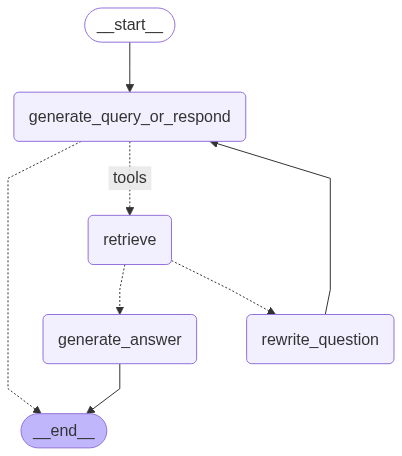

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## 9. Run the agentic RAG

In [ ]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "How can I create a CuPy-backed Dask array for random data?",
            }
        ]
    }
):
    for node, update in chunk.items():
        print("Update from node", node)
        update["messages"][-1]
        print("\n\n")

Update from node generate_query_or_respond



Update from node retrieve



Update from node rewrite_question



Update from node generate_query_or_respond





## Naive Rag Chat Interface


In [ ]:
import gradio as gr

def ask_graph(user_input, chat_history):
    result = graph.invoke({
        "messages": [
            {"role": "user", "content": user_input}
        ]
    })

    response = result["messages"][-1].content

    if not chat_history:
        response = [{"role": "user", "content": user_input}, {"role": "assistant", "content": response}]
    else:
        response = chat_history + [{"role": "user", "content": user_input}, {"role": "assistant", "content": response}]

    return "", response

def clear_conversation():
    return "", ""

with gr.Blocks(fill_height=True, fill_width=True) as demo:
    gr.Markdown("### Agentic RAG")

    with gr.Column():

        with gr.Row():
            chatbot = gr.Chatbot(height=350, type="messages")

        with gr.Row():
            with gr.Column(scale=4):
                query_input = gr.Textbox(
                    label="Enter text here", placeholder="Ask something...", lines=1
                    )
            with gr.Column(scale=1):
                with gr.Row():
                    submit_btn = gr.Button("⬆")
                # 🧹 Clear button
                with gr.Row():
                    clear_btn = gr.Button("🧹 Clear Conversation")

        submit_btn.click(
            fn=ask_graph,
            inputs=[query_input, chatbot],
            outputs=[query_input, chatbot],
        )

        query_input.submit(
            fn=ask_graph,
            inputs=[query_input, chatbot],
            outputs=[query_input, chatbot],
        )

        clear_btn.click(
            fn=clear_conversation,
            outputs=[query_input, chatbot],
        )

demo.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://a7ea9700dce92e4ff9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Separated Chat Interface (Naive Rag vs Base Model llama )

In [ ]:
import gradio as gr
import time
import random

# Mock chatbot functions - replace these with your actual chatbot APIs
def chatbot_a_response(message, history):
    """Simulate Chatbot A response"""
    if not message.strip():
        return "", history

    time.sleep(1)  # Simulate processing time
    response = chat.send(message)

    # Update gradio history format using messages format
    history.append({"role": "user", "content": message})
    history.append({"role": "assistant", "content": response})
    return "", history

def chatbot_b_response(message, chat_history):
    """Simulate Chatbot B response"""
    if not message.strip():
        return "", chat_history

    time.sleep(1.2)  # Simulate different processing time
    result = graph.invoke({
        "messages": [
            {"role": "user", "content": message}
        ]
    })
    response = result["messages"][-1].content

    if not chat_history:
        updated_history = [{"role": "user", "content": message}, {"role": "assistant", "content": response}]
    else:
        updated_history = chat_history + [{"role": "user", "content": message}, {"role": "assistant", "content": response}]

    return "", updated_history

def clear_chat_a():
    """Clear chat A history"""
    chat.clear_history()
    return []

def clear_chat_b():
    """Clear chat B history"""
    return []

# Create the Gradio interface
with gr.Blocks(title="Chatbot Comparison", theme=gr.themes.Soft()) as demo:
    gr.Markdown("# 🤖 Chatbot Performance Comparison")
    gr.Markdown("Compare responses from two different chatbots side by side - each with independent chat")

    with gr.Row():
        # Chatbot A Column
        with gr.Column(scale=1):
            gr.Markdown("### 🔵 Chatbot A")
            chatbot_a = gr.Chatbot(
                height=300,
                show_label=False,
                container=True,
                type="messages"
            )

            with gr.Row():
                msg_a = gr.Textbox(
                    placeholder="Message for Chatbot A...",
                    show_label=False,
                    scale=4,
                    container=False
                )
                send_btn_a = gr.Button("Send", variant="primary", scale=1)

            clear_btn_a = gr.Button("Clear Chat A", variant="secondary", size="sm")

        # Chatbot B Column
        with gr.Column(scale=1):
            gr.Markdown("### 🔴 Chatbot B")
            chatbot_b = gr.Chatbot(
                height=300,
                show_label=False,
                container=True,
                type="messages"
            )

            with gr.Row():
                msg_b = gr.Textbox(
                    placeholder="Message for Chatbot B...",
                    show_label=False,
                    scale=4,
                    container=False
                )
                send_btn_b = gr.Button("Send", variant="primary", scale=1)

            clear_btn_b = gr.Button("Clear Chat B", variant="secondary", size="sm")

    # Add some example prompts for both
    # with gr.Row():
        # with gr.Column(scale=1):
        #     gr.Examples(
        #         examples=[
        #             ["What is artificial intelligence?"],
        #             ["Explain quantum computing in simple terms"],
        #             ["Write a short poem about nature"],
        #             ["What are the benefits of renewable energy?"]
        #         ],
        #         inputs=msg_a,
        #         label="Example prompts for Chatbot A"
        #     )

        # with gr.Column(scale=1):
        #     gr.Examples(
        #         examples=[
        #             ["What is artificial intelligence?"],
        #             ["Explain quantum computing in simple terms"],
        #             ["Write a short poem about nature"],
        #             ["What are the benefits of renewable energy?"]
        #         ],
        #         inputs=msg_b,
        #         label="Example prompts for Chatbot B"
        #     )

    # Event handlers for Chatbot A
    send_btn_a.click(
        fn=chatbot_a_response,
        inputs=[msg_a, chatbot_a],
        outputs=[msg_a, chatbot_a]
    )

    msg_a.submit(
        fn=chatbot_a_response,
        inputs=[msg_a, chatbot_a],
        outputs=[msg_a, chatbot_a]
    )

    clear_btn_a.click(
        fn=clear_chat_a,
        outputs=[chatbot_a]
    )

    # Event handlers for Chatbot B
    send_btn_b.click(
        fn=chatbot_b_response,
        inputs=[msg_b, chatbot_b],
        outputs=[msg_b, chatbot_b]
    )

    msg_b.submit(
        fn=chatbot_b_response,
        inputs=[msg_b, chatbot_b],
        outputs=[msg_b, chatbot_b]
    )

    clear_btn_b.click(
        fn=clear_chat_b,
        outputs=[chatbot_b]
    )

# Launch the interface
if __name__ == "__main__":
    demo.launch(
        share=True,  # Set to True to create a public link
        server_name="0.0.0.0",  # Allow external connections
        # Let Gradio automatically find an available port
        # server_port=7860  # Comment out or remove this line
    )

* Running on local URL:  http://0.0.0.0:7864
* Running on public URL: https://68c44ebc344c27856f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


## 10. Graphic User Interface using Gradio

In [ ]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Sat Jun 28 01:32:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  |   00000000:01:00.0 Off |                    0 |
| N/A   33C    P0             76W /  500W |    7567MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----